# Greedy Interaction Flux Balance Analysis (giFBA):
This notebook will walkthrough the process for utilizing the giFBA extension for cobrapy.

***
## Install Information
### Dependencies
- python $\geq$ 3.8
- cobra $\geq$ 0.27.0
- numpy $\geq$ 1.21
- pandas $\geq$ 1.3
- matplotlib $\geq$ UNKNOWN

### Install
From PyPI:<br>
`pip install gifba`

From Github:<br>
`pip install "git+https://github.com/m-3-lab/giFBA.git@main#subdirectory=package"\`

## giFBA Formula
$f_{n+1, j} = f_{n, j} + \sum_i V_{i, j}(a_i, f_{n, j}, S_i)$ <br>

Variables:
- $n$: Iteration Index
- $i$: Model Index
- $j$: Metabolite Index
- $f_{n, j}$: Media Fluxes
- $V_{i,j}$: Scaled Organism Fluxes
- $a_i$: Relative Abundance
- $S_i$: Model Stoichiometric Matrix



$V_{i,j} = a_i * v_{i, j}$ <br>

$$\begin{align*}
v_{i,j} &= \arg \max c^Tv \\
s.t.& \quad S_i v_i = 0 \\
& \quad \frac{1}{a_i} f_{n, j} \leq v_{i, j} \leq ub \\
\end{align*}$$




# Simple Example giFBA
## Import Package & Models
The package contains the simple communities and media as described in the publication.

## Simulation 1a: Simple Single Organism
![Sim 1a Diagram](Model_Diagrams/sim1a_diagram.png)

![Model Diagrams Legend](Model_Diagrams/legend.png)


In [1]:
import gifba

# load models and media:
model, media = gifba.utils.load_simple_models("1a") # sim. 1a

print("Model type:", type(model)," shape:", len(model))
print("Media", media)

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02
Model type: <class 'list'>  shape: 1
Media {'Ex_A': -10}


Note the format for Models & Media:
- Models: list of cobrapy models
- Media: Dictionary with key: value > Exchange Reaction ID: available flux amount


## Creating Community Class & Running giFBA:
Community: Class representation for giFBA community model

`class gifba.community.Community(model: [cb.Model, list of cb.Model], media: [dict], rel_abund: Optional[None, str, np.ndarray, list] = None, iters: Optional[None, int, float] = None, objective: Optional[None, str] = None, early_stop: Optional[None, bool] = None, v: Optional[None, bool] = None)`<br>
> Class representation for giFBA community model<br><br>

> **Parameters** <br>
> - **model**(*cb.Model or list of cb.Model*) - Single cobra model or list of cobra models in the community to analyze. 
> - **media**(*dict*) - Dictionary with exchange reaction ids (str) as key, absolute value of lower bound (float) as value.
> - **rel_abund**(*str, np.ndarray, list, None, optional*) - Relative abundance of the community. If None or "equal", will automatically default to $\frac{1}{n_{models}}$. If the sum of floats is greater than 1.0, **rel_abund** will automatically normalize values.
> - **iters**(*int, float, None, optional*) - Maximum number of iterations to run. Must be positive. If None, automatically set to 10 iterations.
> - **objective**(*str, None, optional*) - Method of running FBA. Must be "pfba" or "fba" or None. If None, "pfba" is chosen. "pfba" will utilize parsimonious FBA via `cb.flux_analysis.pfba`. "fba" will utilize `cb.model.optimize`.
> - **early_stop**(*bool, None, optional*) - Whether to check convergence or not. If None, will default to True to reduce computational load.
> - **v**(*bool, None, optional*) - Verbose outputs for iteration progress, automatic parameter changes, early stopping check, adjustment for bounds (if competition). If None, False will be declared.

> **Attributes**<br>
> - will go back and edit this
> -
>

> **Methods**<br>
> - will go back and edit this
> -


In [2]:
# initialize community
community = gifba.gifbaObject(model, media) # default relative abundance is "equal" or [1/n, ..., 1/n]

# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", flow = 0.5, early_stop=False, v=True)

Read LP format model from file /tmp/tmp0ez9ktme.lp
Reading time = 0.00 seconds
: 4 rows, 10 columns, 16 nonzeros
Iteration: 0
 Simulating model: 1  of  1
Ex_A [-10.]
exchangeBio1 [-0.]
Objective value: 10.0
Iteration: 1
 Simulating model: 1  of  1
Ex_A [-10.]
exchangeBio1 [-5.]
Objective value: 10.0
Iteration: 2
 Simulating model: 1  of  1
Ex_A [-10.]
exchangeBio1 [-10.]
Objective value: 10.0
Iteration: 3
 Simulating model: 1  of  1
Ex_A [-10.]
exchangeBio1 [-15.]
Objective value: 10.0
Iteration: 4
 Simulating model: 1  of  1
Ex_A [-10.]
exchangeBio1 [-20.]
Objective value: 10.0


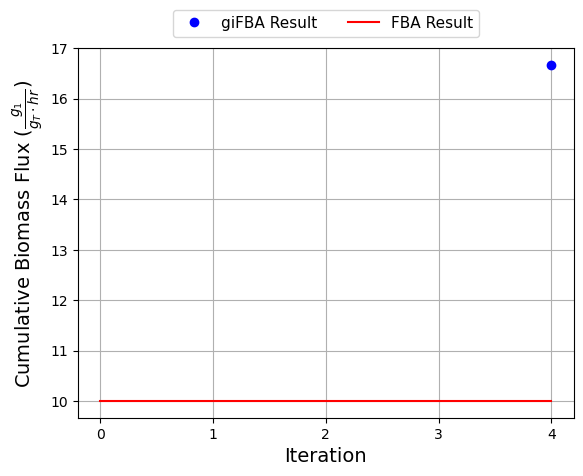

In [3]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np

bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
plt.plot(bio1_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)

# compared to cobrapy FBA
for ex, flux in media.items():
	model[0].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = model[0].optimize().objective_value
plt.plot([bio1_fba]*community.iters, color='r', label='FBA Result', zorder=2)

axis_lab_size = 14
plt.grid()
plt.xlabel("Iteration", fontsize=axis_lab_size)
plt.xticks(np.arange(0, community.iters, 1))
plt.ylabel(r"Cumulative Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
# plt.ylim(0, 25)
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=2) 

plt.savefig("Results/giFBA_Simple/gifba_sim1a.svg", bbox_inches='tight')

## Simulation 1b: Single Organism with "Self" Cross-Feeding
![Sim 1b Diagram](Model_Diagrams/sim1b_diagram.png)

In [163]:
import gifba

# load models and media:
model, media = gifba.utils.load_simple_models("1b") # sim. 1b

# initialize community
community = gifba.gifbaObject(model, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)


Iteration: 0
 Simulating model: 1  of  1
Iteration: 1
 Simulating model: 1  of  1
Iteration: 2
 Simulating model: 1  of  1
Iteration: 3
 Simulating model: 1  of  1
Iteration: 4
 Simulating model: 1  of  1


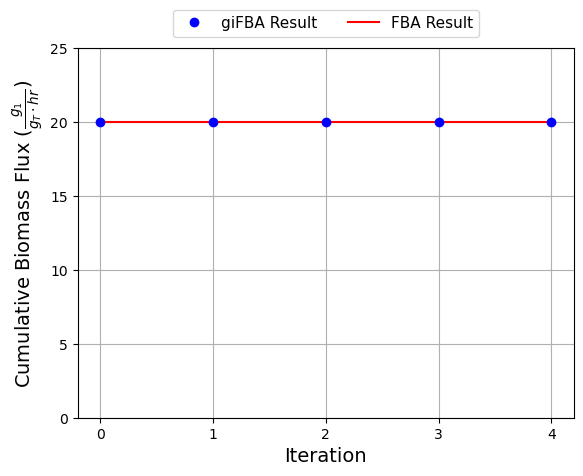

In [164]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np

bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
plt.plot(bio1_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)

# compared to cobrapy FBA
for ex, flux in media.items():
	model[0].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = model[0].optimize().objective_value
plt.plot([bio1_fba]*community.iters, color='r', label='FBA Result', zorder=2)

axis_lab_size = 14
plt.grid()
plt.xlabel("Iteration", fontsize=axis_lab_size)
plt.xticks(np.arange(0, community.iters, 1))
plt.ylabel(r"Cumulative Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylim(0, 25)
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=2) 

plt.savefig("Results/giFBA_Simple/gifba_sim1b.svg", bbox_inches='tight')

## Simulation 1c: Non-interacting Community with 2 Organisms
![Sim 1c Diagram](Model_Diagrams/sim1c_diagram.png)

In [1]:
import gifba

# load models and media:
sim = "1c"
models, media = gifba.utils.load_simple_models(sim) # sim. 1c

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", flow=0.25, early_stop=False, v=True)


Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02
Read LP format model from file /tmp/tmpula2jt53.lp
Reading time = 0.00 seconds
: 4 rows, 10 columns, 16 nonzeros
Read LP format model from file /tmp/tmp3u640kw0.lp
Reading time = 0.00 seconds
: 4 rows, 10 columns, 16 nonzeros
Iteration: 0
 Simulating model: 1  of  2
Objective value: 20.0
 Simulating model: 2  of  2
Objective value: 20.0
Iteration: 1
 Simulating model: 1  of  2
Objective value: 10.0
 Simulating model: 2  of  2
Objective value: 10.0
Iteration: 2
 Simulating model: 1  of  2
Objective value: 7.5
 Simulating model: 2  of  2
Objective value: 7.5
Iteration: 3
 Simulating model: 1  of  2
Objective value: 6.875
 Simulating model: 2  of  2
Objective value: 6.875
Iteration: 4
 Simulating model: 1  of  2
Objective value: 6.71875
 Simulating model: 2  of  2
Objective value: 6.71875
Total iterations run: 4


In [2]:
community.env_fluxes

,exchangeBio2,Ex_B,Ex_A,exchangeBio1
Iteration,,,,
0,0.000000,10.000000,10.000000,0.000000
1,7.500000,5.000000,5.000000,7.500000
2,11.250000,3.750000,3.750000,11.250000
3,14.062500,3.437500,3.437500,14.062500
4,16.640625,3.359375,3.359375,16.640625
5,19.160156,3.339844,3.339844,19.160156


In [5]:
community.org_fluxes / ((community.iter_converged) * community.flow* 10)
# print((community.iter_converged+1) * community.flow)
# community.iter_converged

,,BiomassOrg1,Ex_B,BiomassOrg2,exchangeBio1,T_B,T_Bio2,T_Bio1,exchangeBio2,T_A,Ex_A
Model,Iteration,,,,,,,,,,
0,0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000
1,0,0.000000,-1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
0,1,1.500000,0.000000,0.000000,1.500000,0.000000,0.000000,1.500000,0.000000,1.500000,-1.500000
1,1,0.000000,-1.500000,1.500000,0.000000,1.500000,1.500000,0.000000,1.500000,0.000000,0.000000
0,2,1.875000,0.000000,0.000000,1.875000,0.000000,0.000000,1.875000,0.000000,1.875000,-1.875000
1,2,0.000000,-1.875000,1.875000,0.000000,1.875000,1.875000,0.000000,1.875000,0.000000,0.000000
0,3,2.218750,0.000000,0.000000,2.218750,0.000000,0.000000,2.218750,0.000000,2.218750,-2.218750
1,3,0.000000,-2.218750,2.218750,0.000000,2.218750,2.218750,0.000000,2.218750,0.000000,0.000000
0,4,2.554688,0.000000,0.000000,2.554688,0.000000,0.000000,2.554688,0.000000,2.554688,-2.554688


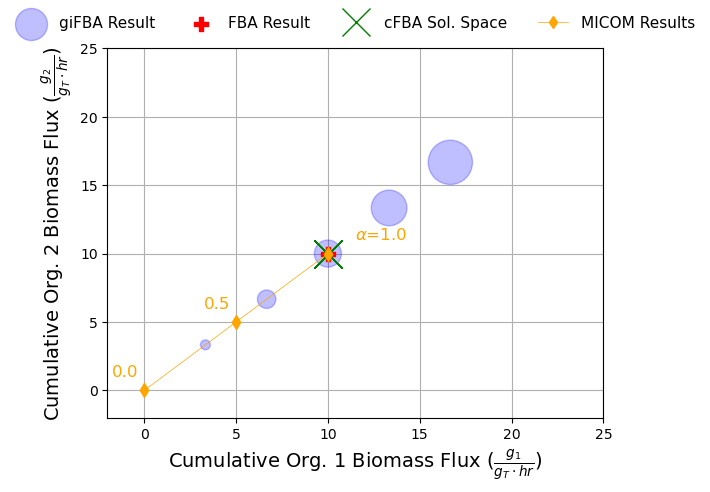

In [7]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = community.org_fluxes.loc[0, :]["exchangeBio1"]
bio2_gifba = community.org_fluxes.loc[1, :]["exchangeBio2"]
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, 
			str(alpha_tradeoff),
			fontsize=12, 
			zorder=3, 
			color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, 
				c=colors[3], 
				marker="d", 
				zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx+1.5, posy+1, 
		r"$\alpha$=1.0",
		fontsize=12, 
		zorder=3, 
		color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, 
			c=colors[3], 
			marker="d", 
			zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

## Simulation 2a: Simple Competition
![Sim 2a Diagram](Model_Diagrams/sim2a_diagram.png)

In [248]:
import gifba

# load models and media:
sim = "2a"
models, media = gifba.utils.load_simple_models(sim) # sim. 2a

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)


Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Ex_A over-consumed by factor of 2.0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


If both models are optimized to consume a metabolite, there is a chance more metabolite will be taken up than is available. This is called the overshoot, which is the ratio of total consumed flux of metabolites to available flux in the media. If any overshoot variable is greater than 1, then more metabolite was consumed than is available. In this case, the algorithm will adjust all lower bounds relative to the metabolite with the maximum uptake. The adjustment factor follows:<br>


$lb_j = \frac{V_{i, j} f_{n, j}}{\sum_i a_i V_{i, j^*}}$
 
 **Variables**:
 > - $lb_j$ : Lower Bound for Exchange of Metabolite $j$
 > - $j^* = \arg \max_j OS_j$ : Metabolite of Maximum Overshoot
 > - $OS_j = \frac{\sum_i V_{i,j}}{f_{n, j}}$ : Overshoot Factor

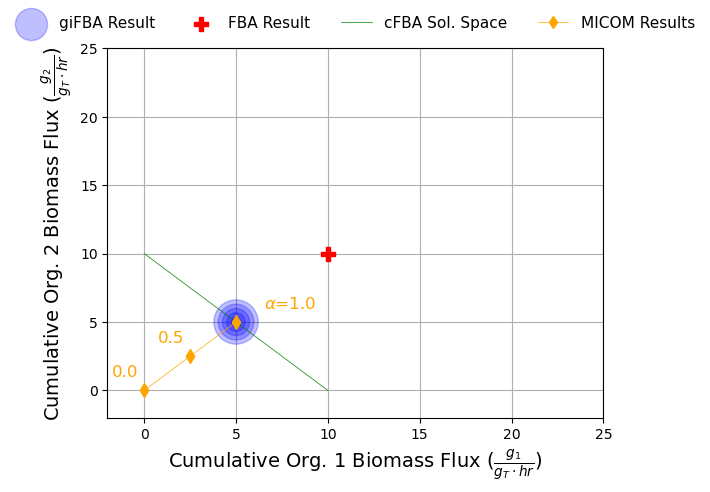

In [249]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			lw=micom_line_width, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, c=colors[3], marker="d", zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx+1.5, posy+1, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

Simple FBA, cannot handle community interactions unless modified for compartmentalized FBA.

## Simulation 2b: Simple Competition (Unequal Abundances)
![Sim 2b Diagram](Model_Diagrams/sim2b_diagram.png)

Now we can adjust the relative abundance of the community and see the difference

In [184]:
import gifba

# load models and media:
sim = "2b"
models, media = gifba.utils.load_simple_models(sim) # sim. 2b
# initialize community
community = gifba.gifbaObject(models, media, rel_abund=[0.2, 0.8])  # relative abundances of each organism
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)

Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Ex_A over-consumed by factor of 2.0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


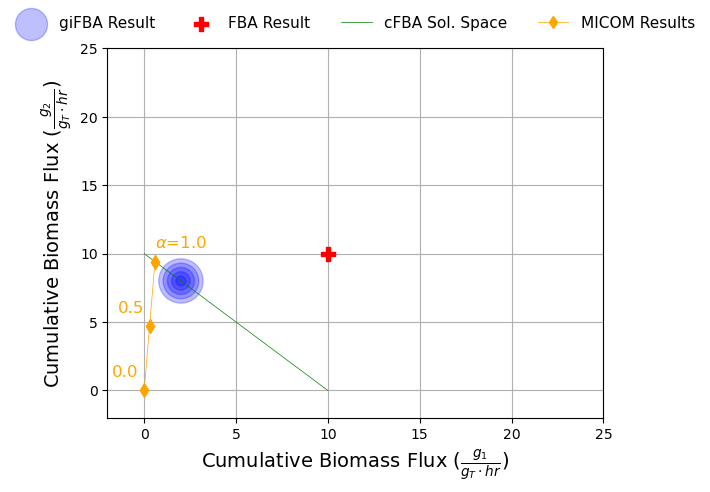

In [ ]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			lw=micom_line_width, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, 
			str(alpha_tradeoff),
			fontsize=12, 
			zorder=3, 
			color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, 
				c=colors[3], 
				marker="d", 
				zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx+0, posy+1, 
		r"$\alpha$=1.0",
		fontsize=12, 
		zorder=3, 
		color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, 
			c=colors[3], 
			marker="d", 
			zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

We expect an organism with 4 times the abundance, to have an initial biomass flux that is 4 times its competitor.

## Simulation 2c: Simple Competition (Unequal Rates)
![Sim 2c Diagram](Model_Diagrams/sim2c_diagram.png)

In [203]:
import gifba

# load models and media:
sim = "2c"
models, media = gifba.utils.load_simple_models(sim) # sim. 2c

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)


Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


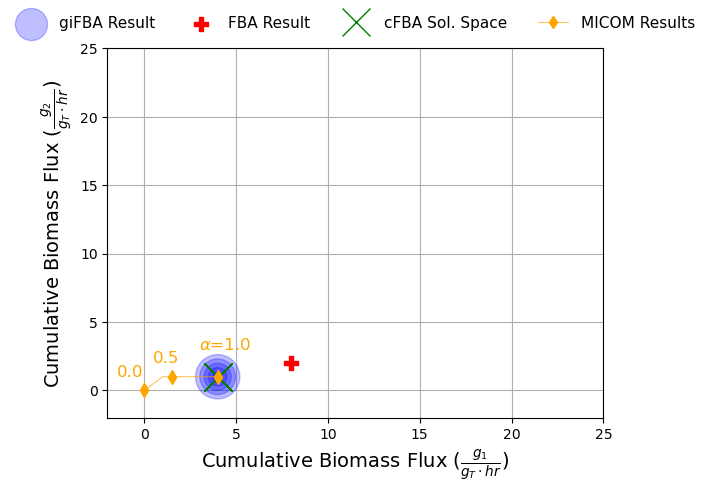

In [ ]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
alpha_tradeoff = 0.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1.5, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 0.5
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1, posy+1, str(alpha_tradeoff),
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1, posy+2, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

## Simulation 2d: Simple Competition (Unequal Rates)
![Sim 2d Diagram](Model_Diagrams/sim2d_diagram.png)

In [213]:
import gifba

# load models and media:
sim = "2d"
models, media = gifba.utils.load_simple_models(sim) # sim. 2d

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)


Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


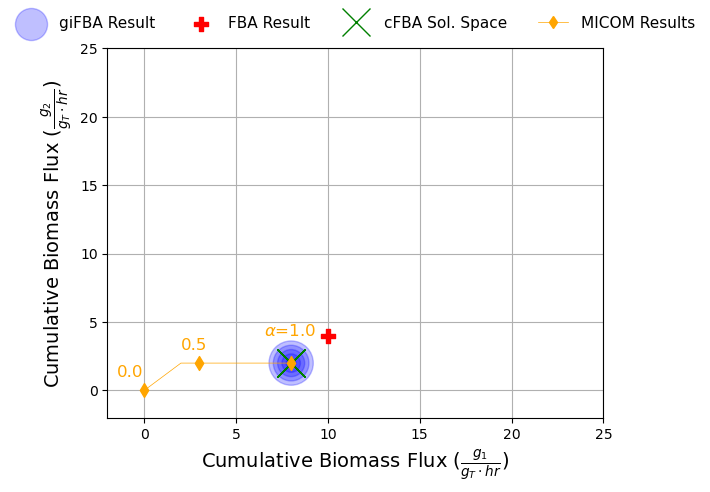

In [ ]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
alpha_tradeoff = 0.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1.5, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 0.5
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1, posy+1, str(alpha_tradeoff),
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1.5, posy+2, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

In [218]:
import gifba

# load models and media:
sim="2e"
models, media = gifba.utils.load_simple_models(sim) # sim. 2e

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)


Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encounter

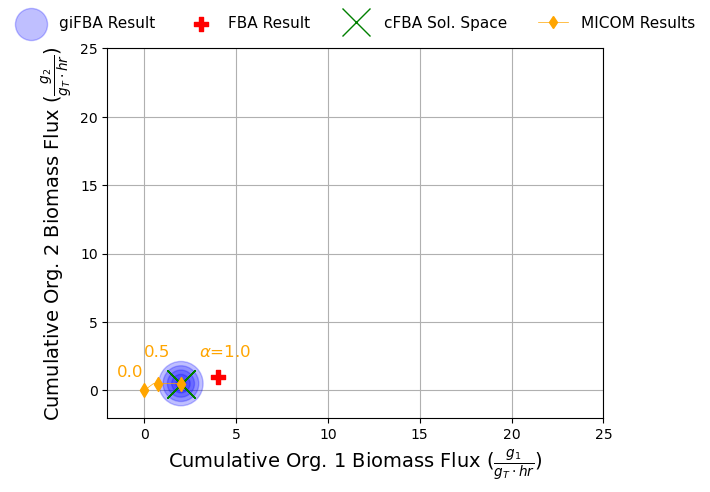

In [225]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
alpha_tradeoff = 0.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-1.5, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 0.5
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-0.75, posy+2, str(alpha_tradeoff),
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx+1, posy+2, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

## Simulation 3a: Simple Cross-Feeding Between 2 Organisms
![Sim 3a Diagram](Model_Diagrams/sim3a_diagram.png)

In [226]:
import gifba

# load models and media:
sim = "3a"
models, media = gifba.utils.load_simple_models(sim) # sim. 3a

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)



Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


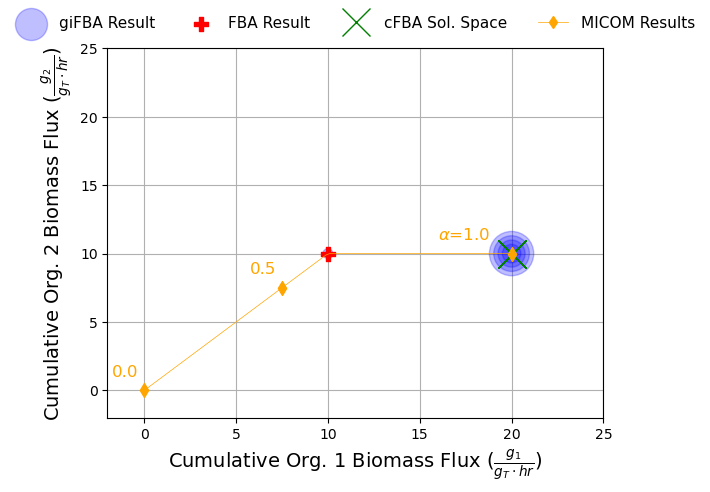

In [232]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, c=colors[3], marker="d", zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-4, posy+1, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

Notice that end behavior matches between:
- Simulation 3a, Organism 1 & Simulation 1b
- Simulation 3a, Organism 2 & Simulation 1a

## Simulation 3b: Multi-Step Cross-Feeding
![Sim 3b Diagram](Model_Diagrams/sim3b_diagram.png)

In [233]:
import gifba

# load models and media:
sim = "3b"
models, media = gifba.utils.load_simple_models(sim) # sim. 3b

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations+
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)

Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


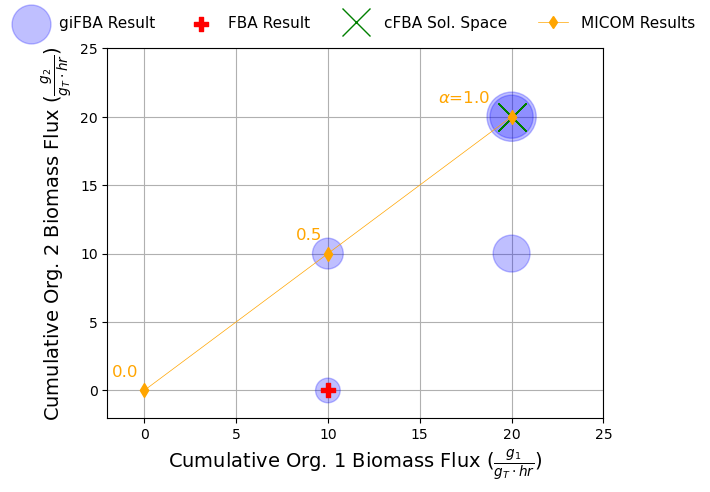

In [239]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(10, 20, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, c=colors[3], marker="d", zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-4, posy+1, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

Notice, more iterations are required for convergence. This is evident in Simulation 3a, but made more clear in Simulation 3b. This is due to metabolites being added/returned to the media for cross-feeding after each iteration. Additionally, this emergent iteraction is not picked up by normal FBA.


## Simulation 3c: Cross-Feeding & Competition Between 2 Organisms
![Sim 3c Diagram](Model_Diagrams/sim3c_diagram.png)

In [240]:
import gifba

# load models and media:
sim = "3c"
models, media = gifba.utils.load_simple_models(sim) # sim. 3c

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)

Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Ex_A over-consumed by factor of 2.0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


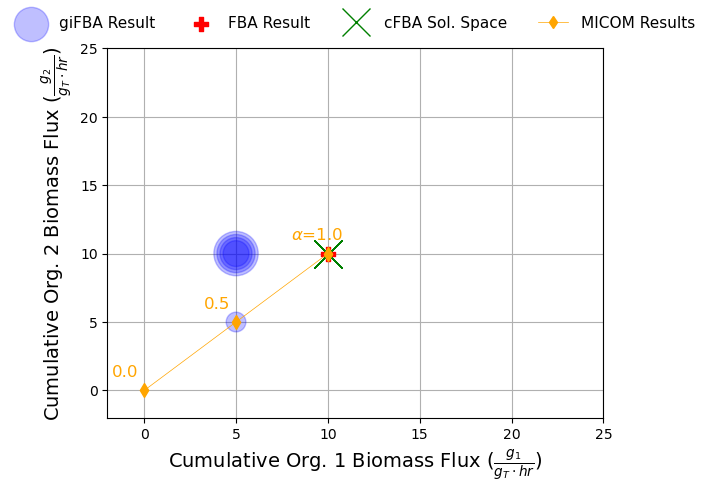

In [244]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(8, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, c=colors[3], marker="d", zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-2, posy+1, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

## Simulation 4: Superfluous Cross-Feeding
![Sim 4a Diagram](Model_Diagrams/sim4a_diagram.png)

In [245]:
import gifba

# load models and media:
sim = "4a"
models, media = gifba.utils.load_simple_models(sim) # sim. 4a

# initialize community
community = gifba.gifbaObject(models, media)
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=False, v=True)

Iteration: 0
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 1
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 2
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 3
 Simulating model: 1  of  2
 Simulating model: 2  of  2
Iteration: 4
 Simulating model: 1  of  2
 Simulating model: 2  of  2


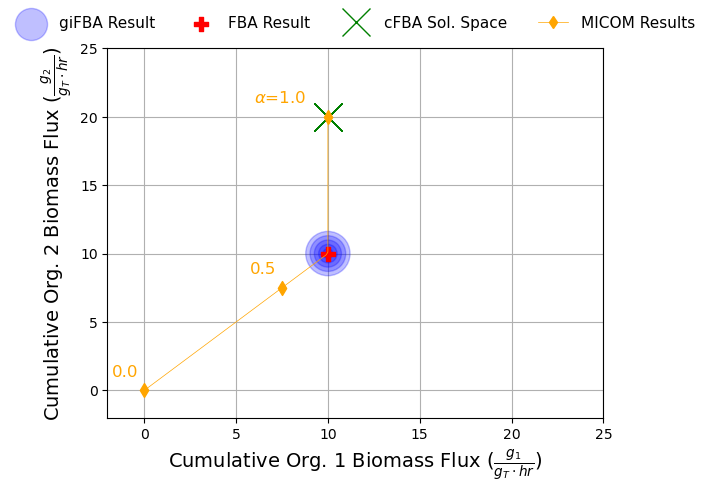

In [246]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
bio1_gifba = np.cumsum(org_flux.loc[0, :]["exchangeBio1"])
bio2_gifba = np.cumsum(org_flux.loc[1, :]["exchangeBio2"])
plt.scatter(bio1_gifba, bio2_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)


# compared to cobrapy FBA
models, media = gifba.utils.load_simple_models(sim) # reload models (since giFBA changed them)
for model in models:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
for ex, flux in media.items():
	if ex in models[0].exchanges:
		models[0].exchanges.get_by_id(ex).lower_bound = flux
for ex, flux in media.items():
	if ex in models[1].exchanges:
		models[1].exchanges.get_by_id(ex).lower_bound = flux
bio1_fba = models[0].optimize().objective_value
bio2_fba = models[1].optimize().objective_value
plt.scatter(bio1_fba, bio2_fba, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)


# compared to cFBA
cfba = pd.read_csv(f"Results/cFBA/cFBA_results_sim{sim}.csv", index_col=False)
plt.plot(cfba["First_Org_Flux"], cfba["Second_Org_Max_Flux"],
			color=colors[2], 
			marker="x", 
			ms=cfba_marker_size,  
			lw=0, 
			label='cFBA Sol. Space',
			zorder=3)


# compared to MICOM
micom = pd.read_csv("Results/micom_results.csv", index_col=0)
micom = micom.loc[sim]
plt.plot(micom["Org1_growth"], micom["Org2_growth"],
			color=colors[3], 
			lw=micom_line_width, 
			ms=micom_marker_size,
			zorder=3)

# label MICOM tradeoff points (only some)
micom_tradeoffs = [0.0, 0.5]
for alpha_tradeoff in micom_tradeoffs:
	posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
	posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
	plt.text(posx-1.75, posy+1, str(alpha_tradeoff),
			fontsize=12, zorder=3, color=colors[3])
	plt.scatter(posx, posy, 
				s=micom_marker_size, c=colors[3], marker="d", zorder=3)
alpha_tradeoff = 1.0
posx = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org1_growth"].values[0]
posy = micom[micom["tradeoff"] == alpha_tradeoff].reset_index()["Org2_growth"].values[0]
plt.text(posx-4, posy+1, r"$\alpha$=1.0",
		fontsize=12, zorder=3, color=colors[3])
plt.scatter(posx, posy, 
			s=micom_marker_size, c=colors[3], marker="d", zorder=3)

# create custom legend entry
micom_handle = plt.Line2D([0], [0], color=colors[3], lw=micom_line_width, marker="d", label='MICOM Results')
handles, labels = plt.gca().get_legend_handles_labels() # pull original legend
handles.append(micom_handle) # add new legend entry
labels.append("MICOM Results") # add new legend entry
plt.legend(handles=handles, labels=labels,
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 

# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative Org. 1 Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative Org. 2 Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.xlim(-2, 25)
plt.ylim(-2, 25)

plt.savefig(f"Results/giFBA_Simple/gifba_sim{sim}.svg", bbox_inches='tight')

# Real-Life Examples
The following examples utilize AGORA2 models to understand how growth compares. These examples will also show how to use the summary class/method for analyzing the community. 

## Example 1: Pairwise Interactions
- Escherichia coli str. K12 substr. MG1655 & Bacterioides thetaiotaomicron 3731
	- [Download Escherichia_coli_str_K_12_substr_MG1655.mat Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Escherichia_coli_str_K_12_substr_MG1655.mat)
	- [Download Bacteroides_thetaiotaomicron_3731.mat Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Bacteroides_thetaiotaomicron_3731.mat)

In [1]:
import cobra as cb
import gifba

EC_path = "AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat"
EC = cb.io.load_matlab_model(EC_path)

BT_path = "AGORA2_Models/Bacteroides_thetaiotaomicron_3731.mat"
BT = cb.io.load_matlab_model(BT_path)

#example glucose minimal media
min_med_ids_ex = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_pi(e)','EX_cys_L(e)',
			'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)',
			'EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
min_med_fluxes_ex = [-10,-100,-100,-100,-100,
					-100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
media = dict(zip(min_med_ids_ex, min_med_fluxes_ex))

# initialize community
community = gifba.gifbaObject([EC, BT], media, rel_abund=[0.5, 0.5])
# run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=True, v=False) # early stopping simply checks if there are ANY changes in the media and quits if not

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_o

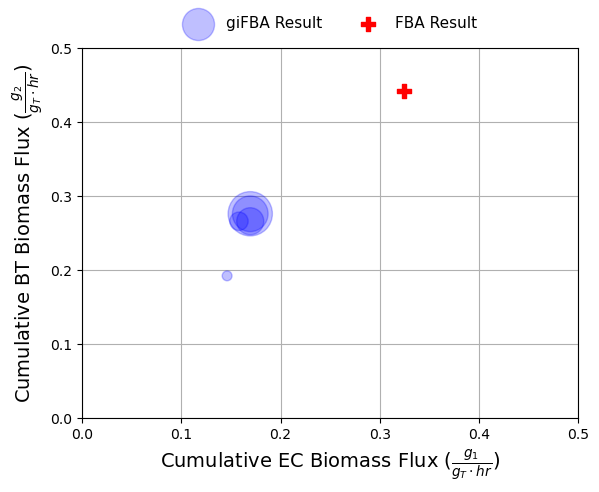

In [9]:
#plot model results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sizes for markers
fba_marker_size, cfba_marker_size, micom_marker_size = 100, 20, 50
gifba_marker_sizes = np.linspace(4, 18, community.iters)**2 * np.pi
micom_line_width = 0.5
colors = ["b", "r", "g", "orange"] # gifba, FBA, cFBA, MICOM


# plot giFBA results
EC_gifba = np.cumsum(org_flux.loc[0, :]["biomass525"])
BT_gifba = np.cumsum(org_flux.loc[1, :]["bio1"])
plt.scatter(EC_gifba, BT_gifba, 
			color=colors[0],
			marker="o", 
			s=gifba_marker_sizes, 
			alpha=0.25,
			label="giFBA Result",
			zorder = 2)

# compared to cobrapy FBA
for ex, flux in media.items():
	if ex in EC.exchanges:
		EC.exchanges.get_by_id(ex).lower_bound = flux
EC_optimal = EC.optimize().objective_value

for ex, flux in media.items():
	if ex in BT.exchanges:
		BT.exchanges.get_by_id(ex).lower_bound = flux
BT_optimal = BT.optimize().objective_value


plt.scatter(EC_optimal, BT_optimal, 
			color=colors[1], 
			marker="P", 
			s=fba_marker_size,
			label='FBA Result',
			zorder=3)



# annotate
axis_lab_size = 14
plt.grid(zorder=0)
plt.xlabel(r"Cumulative EC Biomass Flux ($\frac{g_1}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.ylabel(r"Cumulative BT Biomass Flux ($\frac{g_2}{g_T \cdot hr}$)", fontsize=axis_lab_size)
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=4, frameon=False) 
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.savefig(f"Results/giFBA_AGORA/gifba_ECBT.svg", bbox_inches='tight')

### Community Summary

The Summary Class, made with Community.summary(...) generates a summary table output similar to cobra. The community summary will generate one Uptake/Secretion Subsection for the Community together, then one for each model in the community.

Community: Class representation for an iteration of an iiFBA community

`class iifba.summary.Summary(community:[iifba.Community], iter_shown: Optional[int, None] = None, element: Optional[str] = "C")`<br>
> Class representation for an iteration of an iiFBA community<br><br>

> **Parameters** <br>
> - **Community**(*iifba.Community*) - iifba Community object. If iiFBA has not been run, summary will be generated, but iifba.Community attributes are initialized with zeros, so no significant data will be shown until running `community.iifba()`
> - **iter_shown**(*int, None, optional*) - Iteration to summarize. Defaults to None. If None, the last iteration will be summarized and displayed.
> - **element**(*str,  optional*) - Element to evaluate with summary. Modified from cobrapy summary, will display the flux and percents of the given element. Default element is 'C' for Carbon.

> **Attributes**<br>
> - will go back and edit this
> -
>

> **Methods**<br>
> - will go back and edit this
> -


In [ ]:
# generate community summary
summary = community.summarize()

# save to a cytoscape format
edge, node = summary.to_cytoscape()
edge.to_csv("Results/giFBA_AGORA/EC_BT_edges.csv")
node.to_csv("Results/giFBA_AGORA/EC_BT_nodes.csv")

# display summary
summary

Community Summary (Cumulative through Iteration 4):
Optimization Type: pfba
Sum(Model_i Biomass) = 0.44540151353891955

Uptake:
Metabolite      Exchange      Flux  C-Number C-Flux
  cys_L[e]   EX_cys_L(e)  0.058020         3  0.29%
    fe3[e]     EX_fe3(e)  0.003514         0  0.00%
    cu2[e]     EX_cu2(e)  0.003514         0  0.00%
    mg2[e]     EX_mg2(e)  0.003514         0  0.00%
    ca2[e]     EX_ca2(e)  0.003514         0  0.00%
    mn2[e]     EX_mn2(e)  0.003514         0  0.00%
     pi[e]      EX_pi(e)  0.402995         0  0.00%
cobalt2[e] EX_cobalt2(e)  0.003514         0  0.00%
    fe2[e]     EX_fe2(e)  0.007898         0  0.00%
     cl[e]      EX_cl(e)  0.003514         0  0.00%
  glc_D[e]   EX_glc_D(e) 10.000000         6 99.71%
    so4[e]     EX_so4(e)  0.050477         0  0.00%
    zn2[e]     EX_zn2(e)  0.003514         0  0.00%
    nh4[e]     EX_nh4(e)  3.825799         0  0.00%
      k[e]       EX_k(e)  0.003514         0  0.00%

Secretion:
Metabolite      Exchange    

## Example 2: Larger Community Interactions
The following community comes from [Negative interactions determine Clostridioides difficile growth in synthetic human gut communities](https://www.embopress.org/doi/full/10.15252/msb.202110355#msb202110355-sup-0006)
Figure 3B Displays CommI has the lowest C. difficile abundance and with the lowest richness. This is a great example for demonstrating how iiFBA can show community interactions on communities with more than 2 organisms. CommI composition is detailed in the Data availability section.

To simplify computation and download requirements, the Virtual Metabolic Human ([VMH](vmh.life)) European Diet will be used. The following are models for download:
| Name | Details | Link|
|:----:|:-------:|:---:|
|Average European Diet| Commonly Used Diet from VMH | [Download Avg. EU Diet here](https://vmh.life/#diet/EU%20average)|
|*Clostridium difficile* (*C. diff* or CD)| *C. diff* ribotype 027 is known as hypervirulent | [Download *C. diff* Model Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Clostridium_difficile_R20291.mat)|
|*Clostridium hiranonis* (*C. hiranonis* or CD)| *C. hiranonis* is a *C. diff* competitor | [Download *C. hiranonis* Model Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Clostridium_hiranonis_TO_931_DSM_13275.mat)|
|*Eggerthela lenta* (*E. lenta* or EL)| *E. lenta* is known to promote growth of other bacteria | [Download *E. lenta* Model Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Eggerthella_lenta_DSM_11767.mat)|
|*Bacteroides thetaiotaomicron* (*B. theta* or BT) | Known to compete with *C. diff*. Same model as Above Community|[Download *B. theta* Model Here](https://www.vmh.life/files/reconstructions/AGORA2/version2.01/mat_files/individual_reconstructions/Bacteroides_thetaiotaomicron_3731.mat)|


In [1]:
import cobra as cb
import pandas as pd

# load models
CD_path = "AGORA2_Models/Clostridium_difficile_R20291.mat"
CD = cb.io.load_matlab_model(CD_path)

CH_path = "AGORA2_Models/Clostridium_hiranonis_TO_931_DSM_13275.mat"
CH = cb.io.load_matlab_model(CH_path)

BT_path = "AGORA2_Models/Bacteroides_thetaiotaomicron_3731.mat"
BT = cb.io.load_matlab_model(BT_path)

EL_path = "AGORA2_Models/Eggerthella_lenta_DSM_11767.mat"
EL = cb.io.load_matlab_model(EL_path)

media = "AGORA2_Models/euro_diet.tsv"
media = pd.read_csv(media, sep="\t", header=0, index_col=0).to_dict()
media = media["Flux Value"]
euro_media = {ex.replace("[e]", "(e)"): -flux for ex, flux in media.items()}

#example glucose minimal media
min_med_ids_ex = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_pi(e)','EX_cys_L(e)',
			'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)',
			'EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
min_med_fluxes_ex = [-10,-100,-100,-100,-100,
					-100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
min_media = dict(zip(min_med_ids_ex, min_med_fluxes_ex))


Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Read LP format model from file /tmp/tmp0gy2ixr2.lp
Reading time = 0.00 seconds
: 1318 rows, 3010 columns, 11452 nonzeros
Iteration: 0
 Simulating model: 1  of  1


/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes


Checking Convergence...
Iteration: 1
 Simulating model: 1  of  1
Checking Convergence...
Converged at iteration 1


/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:330: RuntimeWarning: invalid value encountered in divide
  is_overconsumed[env_tmp != 0] = -total_org_flux[np.abs(env_tmp) >= 1e-6].astype(np.longlong) / env_tmp[np.abs(env_tmp) >= 1e-6].astype(np.longlong) # only check non-zero env fluxes


EX_pullulan1200(e) -0.5096000718076933
EX_glc_D(e) -10.0
EX_so4(e) -100.0
EX_nh4(e) -100.0
EX_pi(e) -100.0
EX_cys_L(e) -100.0
EX_mn2(e) -100.0
EX_cl(e) -100.0
EX_ca2(e) -100.0
EX_mg2(e) -100.0
EX_cu2(e) -100.0
EX_cobalt2(e) -100.0
EX_fe2(e) -100.0
EX_fe3(e) -100.0
EX_zn2(e) -100.0
EX_k(e) -100.0
0.0 0.0 14.20046564462888 0.0


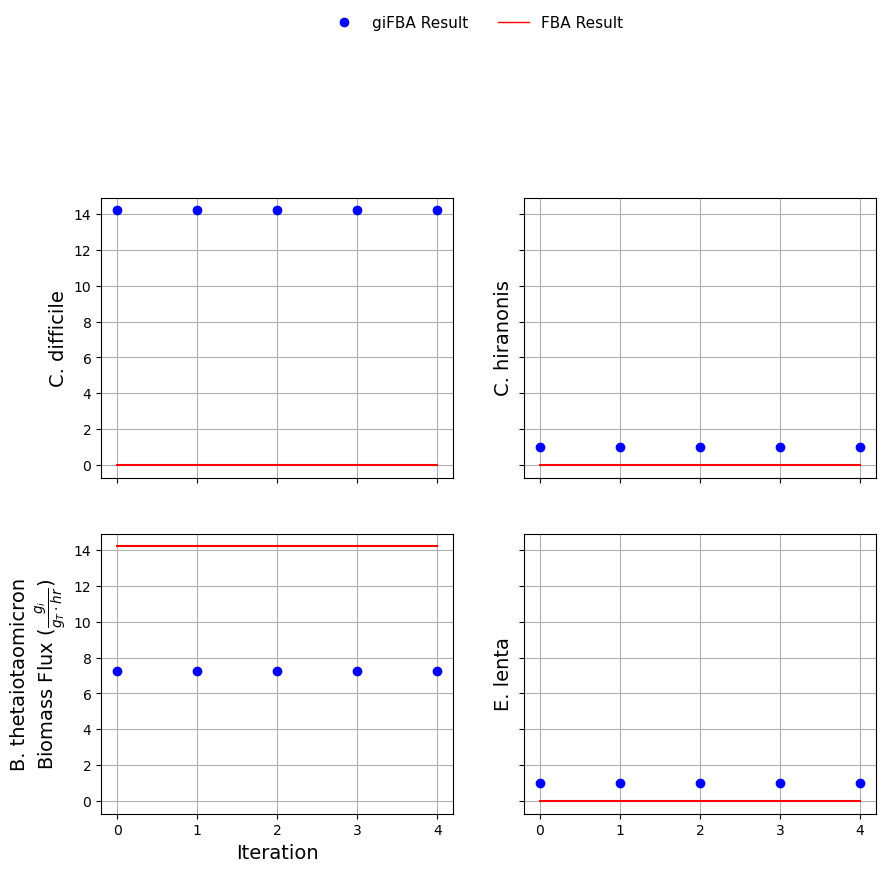

In [ ]:
#plot model results
import gifba
import matplotlib.pyplot as plt
import numpy as np

# # initialize community
community = gifba.gifbaObject([CD, CH, BT, EL], media=[min_media, 1], # minimal media
							rel_abund=[0.1, 0.3, 0.3, 0.3]) # unequal similar to Hromada et al.

# # run iterations
media_flux, org_flux = community.run_gifba(iters=5, method="pfba", early_stop=True, v=True) # early stopping simply checks if there are ANY changes in the media and quits if not


# extract cumulative growth for each organism
CD_gifba = np.cumsum(org_flux.loc[0, :]["EX_biomass(e)"])
CH_gifba = np.cumsum(org_flux.loc[1, :]["EX_biomass(e)"])
BT_gifba = np.cumsum(org_flux.loc[2, :]["EX_biomass(e)"])
EL_gifba = np.cumsum(org_flux.loc[3, :]["EX_biomass(e)"])

# plot giFBA results for each org
fig, ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(10,8))
ax[0, 0].plot(CD_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)
ax[0, 1].plot(CH_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)
ax[1, 0].plot(BT_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)
ax[1, 1].plot(EL_gifba, lw=0, marker="o", color="b", label="giFBA Result", zorder=3)

# compared to cobrapy FBA
# reset model bounds, set media, simulate
# CD
media = community.media
with CD as model:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
	for ex, flux in media.items():
		if ex in model.exchanges:
			model.exchanges.get_by_id(ex).lower_bound = flux
	CD_fba = model.optimize().objective_value
# fba for CH
with CH as model:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
	for ex, flux in media.items():
		if ex in model.exchanges:
			model.exchanges.get_by_id(ex).lower_bound = flux
	CH_fba = model.optimize().objective_value
# fba for BT
with BT as model:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
	for ex, flux in media.items():
		if ex in model.exchanges:
			model.exchanges.get_by_id(ex).lower_bound = flux
	BT_fba = model.optimize().objective_value
# fba for EL
with EL as model:
	for ex in model.exchanges:
		model.exchanges.get_by_id(ex.id).lower_bound = 0
	for ex, flux in media.items():
		print(ex, flux)
		if ex in model.exchanges:
			model.exchanges.get_by_id(ex).lower_bound = flux
	EL_fba = model.optimize().objective_value

print(CD_fba, CH_fba, BT_fba, EL_fba)

ax[0, 0].plot([CD_fba]*community.iters, color='r', label='FBA Result', zorder=2)
ax[0, 1].plot([CH_fba]*community.iters, color='r', label='FBA Result', zorder=2)
ax[1, 0].plot([BT_fba]*community.iters, color='r', label='FBA Result', zorder=2)
ax[1, 1].plot([EL_fba]*community.iters, color='r', label='FBA Result', zorder=2)

ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

# annotate
axis_lab_size = 14
ax[1,0].set_xlabel("Iteration", fontsize=axis_lab_size)
ax[0,0].set_ylabel("C. difficile", fontsize=axis_lab_size)
ax[0,1].set_ylabel("C. hiranonis", fontsize=axis_lab_size)
ax[1,0].set_ylabel("B. thetaiotaomicron\n" + r"Biomass Flux ($\frac{g_i}{g_T \cdot hr}$)", fontsize=axis_lab_size)
ax[1,1].set_ylabel("E. lenta", fontsize=axis_lab_size)

# legend
handles = [plt.Line2D([0], [0], color="b", lw=0, marker="o", label='giFBA Result'),
		   plt.Line2D([0], [0], color="r", lw=1, label='FBA Result')]
fig.legend(handles=handles, labels=["giFBA Result", "FBA Result"],
		   fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=2, frameon=False)

plt.savefig("Results/giFBA_AGORA/gifba_4bactcomm.svg", bbox_inches='tight')

In [5]:
summary = community.summarize()
edges, nodes = summary.to_cytoscape()

# generate community summary
summary = community.summarize()

# save to a cytoscape format
edge, node = summary.to_cytoscape()
edge.to_csv("4bact_comm_edges.csv")
node.to_csv("4bact_comm_nodes.csv")

# display summary
summary 

summary

Metabolite,Exchange,Flux,C-Number,C-Flux
26dap_M[e],EX_26dap_M(e),1.366000e-02,7,0.01%
fol[e],EX_fol(e),9.289500e-03,19,0.01%
pheme[e],EX_pheme(e),4.576500e-03,34,0.01%
fe2[e],EX_fe2(e),3.259800e-02,0,0.00%
thr_L[e],EX_thr_L(e),1.132440e+01,4,3.66%
pro_L[e],EX_pro_L(e),3.282939e-01,5,0.13%
glc_D[e],EX_glc_D(e),1.906775e+01,6,9.23%
ser_L[e],EX_ser_L(e),2.934448e+00,3,0.71%
glypro[e],EX_glypro(e),1.117564e-01,7,0.06%
pydx[e],EX_pydx(e),1.066194e-02,8,0.01%
